# Setup

In [1]:
import random
import string
import os

from pylibdmtx.pylibdmtx import encode, decode
from PIL import Image

from torchvision.transforms import v2
import torch

import numpy as np

# Setting Parameters (UPDATE THIS)

To synthesize Data Matrix Codes with a texture to later multiply onto, I do the following steps for each datapoint:

- Generate a randomized string in following letter (L) number (N) format:
    - NLNLNNNNNNN + NNNN
    - \+ NNNN denotes the last 4 numbers in a serial number which increment by 1. Therefore this will range from 0000 to 0100 to mimic the real-world data more closely.
- Generate Data Matrix Code from the randomized string
- Grab a random texture from "../../data/textures/"
- Take a 512/512 random crop of the texture image using pytorch v2.RandomCrop((512,512))

The DMCs and textures are combined into tensors and saved under "../../data/synth_data_new/"

Each tensor is just shy of 4.1MB, so with 1000 generated datapoints we create ~4.1GB of images.

## Helpers

In [2]:
def gen_string():
    '''
    Generates a serial number to encode
    
    Serial numbers are:
    - 11 characters long
    - Index 0, 2, 4, 5, 6, 7, 8, 9, 10 are random digits
    - Index 1 and 3 are uppercase letters
    - Index 11, 12, 13, 14 are an incremental number starting from 0001

    Example serial number: 4 L 4 N 0418028 0001
    '''

    to_encode = ''

    # first 11 indexes
    for j in range(11):
        # 1 and 3 are uppercase
        if j in [1, 3]:
            to_encode += random.choice(string.ascii_uppercase)
        else:
            to_encode += str(random.randrange(0, 10))

    # last 4 indexes
    end = str(random.randrange(1, 99))
    if len(end) == 1:
        end = '0' + end
    elif len(end) == 2:
        end = '00' + end
    else:
        end = '000' + end
    to_encode += end

    return to_encode

def encode_image(to_encode):
    '''Creates a PIL image containing DMC encoding of given string'''

    encoded = encode(to_encode.encode('utf8'))
    img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels).convert('L')

    # crop image to remove white borders (have to leave some white border to do decode check)
    img = img.crop((9, 9, img.width-9, img.height-9))

    # upscale image
    img = img.resize((512, 512), Image.NEAREST)

    return img

def get_texture_crop(textures_path, debug=False):
    '''Gets a random texture image from the given path and returns a random crop'''

    texture = random.choice(os.listdir(textures_path))

    if debug:
        print(texture)

    texture = Image.open(os.path.join(textures_path, texture))

    # get random crop
    transform = v2.Compose([
        v2.RandomCrop((512, 512))
    ])
    texture = transform(texture)

    return texture

def combine_to_tensor(dmc_img, texture_img):
    '''Combines the DMC image and texture image into a single tensor'''

    # convert to tensors
    transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
    dmc_img = transform(dmc_img)
    texture_img = transform(texture_img)

    # combine images
    combined = torch.cat((dmc_img, texture_img), dim=0)

    return combined

image-from-rawpixel-id-5921174-original.jpg


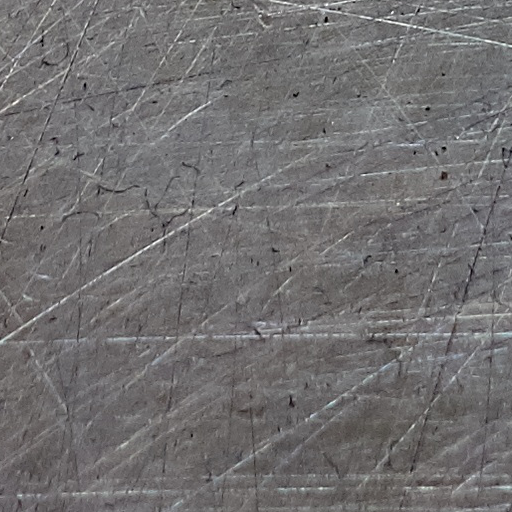

In [3]:
# testing texture crops (uncomment debug print)
get_texture_crop('../../data/textures/', debug=True)

## Main Function

"gen_imgs" takes in params and uses helpers to synthesize ground truth and background image

Example serial number: 2C7E67587210018


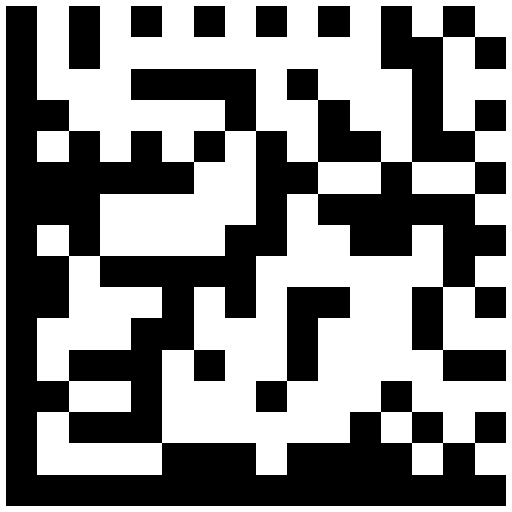

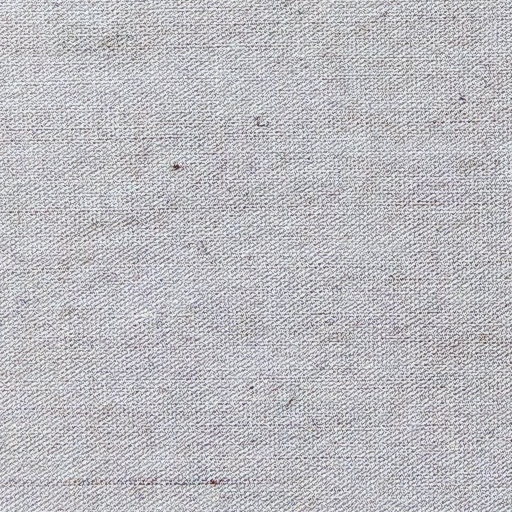

Example combined tensor shape: torch.Size([4, 512, 512])
Example tensor values: tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.8353, 0.9059, 0.6588, 0.8902, 0.9373],
        [0.8392, 0.9098, 0.6706, 0.9020, 0.9490],
        [0.8588, 0.9294, 0.6980, 0.9294, 0.9765]])


In [4]:
def gen_imgs(N_imgs, textures_path):
    '''Generates N images'''
    i = len(os.listdir('../../data/synth_data_new/'))
    printed_example = False
    while i < N_imgs:

        # generate string to encode into DMC
        to_encode = gen_string()
        ground_truth = encode_image(to_encode)
        # display(ground_truth)
        # break

        # check if image can be decoded, if not, regenerate (this forces us to only generate pylibdmtx decodable images)
        decoded = decode(ground_truth, timeout=1000)
        if not decoded:
            continue

        texture = get_texture_crop(textures_path)
        # display(texture)
        # break

        # combine images into a single tensor
        combined = combine_to_tensor(ground_truth, texture)
        # print(combined.shape)
        # break

        # save generated tensors
        torch.save(combined, f'../../data/synth_data_new/{i}.pt')
        
        if not printed_example:
            print(f'Example serial number: {to_encode}')
            display(ground_truth)
            display(texture)
            print(f'Example combined tensor shape: {combined.shape}')
            print(f'Example tensor values: {combined[:5, :5, 0]}')
            printed_example = True
        
        # print progress
        if i % 100 == 0:
            print(f'{i}/{N_imgs}', end='\r')

        i += 1
    return

# on average, the size of a pair of color_img and ground_truth iamges are 600KB
# so the total size of the dataset will be 10,000 * 600KB = 6,000,000KB = ~6GB

# generates randomized imgs until N_imgs are present in the dataset
N_imgs = 1000
gen_imgs(N_imgs, textures_path='../../data/textures/')

# Example of how to load the data

C:\Users\aidan\AppData\Local\Temp\ipykernel_10376\1997263785.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('../../data/synth_data_new/0.pt')


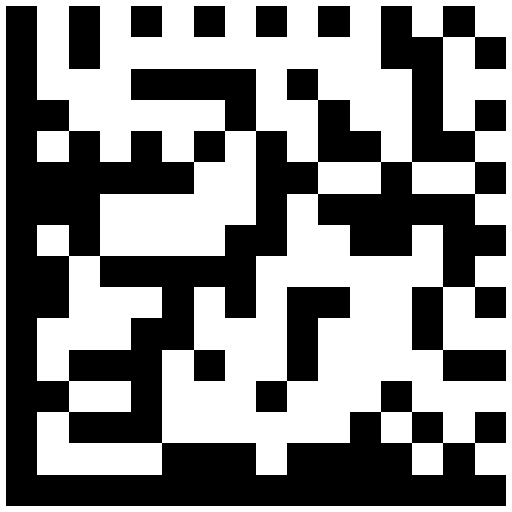

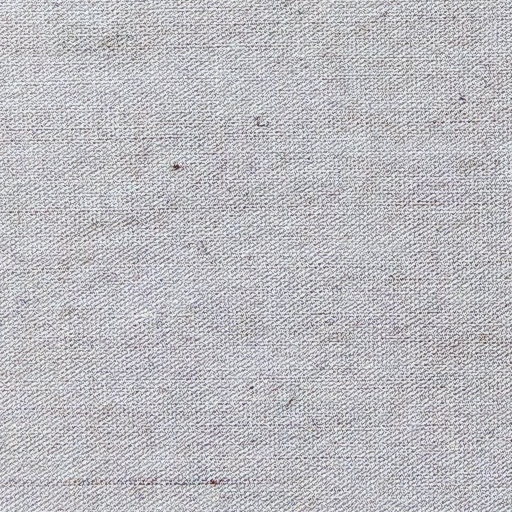

In [5]:
data = torch.load('../../data/synth_data_new/0.pt')

# split into DMC and texture images
dmc_img = data[0].numpy()
texture_img = data[1:].numpy()

# multiply by 255 to convert to 0-255 range
dmc_img = dmc_img * 255
texture_img = texture_img * 255

# convert to uint8
dmc_img = dmc_img.astype(np.uint8)
texture_img = texture_img.astype(np.uint8)

# reshape dmc_img to 2D
dmc_img = dmc_img.reshape(512, 512)

# reshape texture_img to 3D with 3 channels
texture_img = texture_img.reshape(3, 512, 512).transpose(1, 2, 0)

# convert to PIL images
dmc_img = Image.fromarray(dmc_img).convert('L')
texture_img = Image.fromarray(texture_img).convert('RGB')

display(dmc_img, texture_img)